<h1 id="weather_station_clustering" align="center"> Clustering Ghanaian households based on their expenditure patterns</h1>
<hr>

#### 1.5 Model Training - Part 2

#### DEEP LEARNING ALGORITHMS

In this second part, we will build deep learning clustering models (and 1 non-deep learning clustering model) and compare the results. We will also compare the results to results in the first part of the model training phase of this project. Lastly, we will find the number of optimal clusters for the kmeans clustering algorithm.  

a. kmeans clustering algorithm

b. autoencoder + kmeans

c. DEC ( Deep Embedded Clustering) with autoencoder and kmeans

d. Autoencoder + HDBSCAN

e. Autoencoder + DBSCAN

Importing necessary libraries

In [51]:
%pylab inline
import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score



Populating the interactive namespace from numpy and matplotlib


/home/jupyterlab/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread', 'time', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [52]:
#!pip install metrics
import metrics

Also. lets import the DEC algorithm

In [54]:
!git clone https://github.com/XifengGuo/DEC-keras
!cd DEC-keras

fatal: destination path 'DEC-keras' already exists and is not an empty directory.


In [55]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

Import data

In [56]:
import pandas as pd
df = pd.read_csv('df_norm_dataframe.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)


Renaming the dataset

In [58]:
train = df
train.head()

,totfood,totalch,totclth,tothous,totfurn,tothlth,tottrsp,totcmnq,totrcre,toteduc,totmisc
0,0.869768,-0.282063,0.813326,0.597423,0.930850,0.270093,0.381865,-0.274590,-0.216681,-0.115215,0.970906
1,0.333146,-0.282063,-0.095515,3.937930,1.783318,-0.204459,-0.270768,0.137049,-0.224311,0.806321,-0.077166
2,-0.524523,-0.282063,-0.488894,0.058295,-0.199684,-0.182889,-0.331876,-0.261965,-0.265152,-0.282872,0.781011
3,0.234851,-0.282063,1.200771,0.042361,0.104170,-0.182889,0.486971,0.487875,-0.278814,-0.187837,0.737953
4,2.104382,-0.282063,0.356362,0.286199,1.399336,6.288280,-0.007448,0.594741,-0.195824,0.020165,0.877056


#### a. KMEANS CLUSTERING - WITH NORMALIZED DATA

We will first apply K-Means directly to our data and divide it into 3 clusters.

Defining the model

In [59]:
km = KMeans(n_clusters=3)

Defining input data

In [60]:
x_train = train.values

Fitting the model to data

In [61]:
kmeans = km.fit(x_train)

Obtain cluster labels

In [62]:
kmeans.labels_[0:10] #first 10 cluster labels

array([0, 0, 2, 0, 0, 2, 2, 2, 2, 0], dtype=int32)

Evaluating the performance of the model using silhouette coefficient

In [63]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(x_train, kmeans.labels_))

Silhouette Coefficient: 0.378


This silhouette score is no better than the results under HDBSCAN (non deep learning). Next, we will consider kmeans + autoencoder

####  b. KMEANS + AUTO-ENCODER


Now instead of only applying K-Means clustering to the data, we will first use an autoencoder to decrease the dimensionality of the data and extract useful information. This information will then be passed to the K-Means algorithm. This can be accustomed to fixing a clustering layer at the end of a decoding layer



Building an autoencoder (deep learning model)

In [64]:
# this is our input placeholder
input_img = Input(shape=(11,)) # 11 FEATURES

# "encoded" is the encoded representation of the input  - extracting relevant information
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(11, activation='softmax')(encoded)

# "decoded" is the lossy reconstruction of the input - decoding relevant information
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='softmax')(decoded)
decoded = Dense(11)(decoded) # 11 features

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [65]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               6000      
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_11 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dense_12 (Dense)             (None, 11)                22011     
_________________________________________________________________
dense_13 (Dense)             (None, 2000)              24000     
_________________________________________________________________
dense_14 (Dense)             (None, 500)               1000500   
__________

In [66]:
#  this model maps an input to its encoded representation
#  encoder = Model(input_img, encoded)

Compiling the model

In [67]:
autoencoder.compile(optimizer='adam', loss='mse')

Now let us train our autoencoder model.

In [68]:
train_history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=1048, validation_data=(x_train, x_train))

Train on 8922 samples, validate on 8922 samples
Epoch 1/50
8922/8922 [==============================] - 5s 616us/step - loss: 1.0001 - val_loss: 1.0000
Epoch 2/50
8922/8922 [==============================] - 5s 529us/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/50
8922/8922 [==============================] - 5s 525us/step - loss: 1.0000 - val_loss: 0.9999
Epoch 4/50
8922/8922 [==============================] - 5s 525us/step - loss: 0.9997 - val_loss: 0.9988
Epoch 5/50
8922/8922 [==============================] - 5s 525us/step - loss: 0.9962 - val_loss: 0.9889
Epoch 6/50
8922/8922 [==============================] - 5s 525us/step - loss: 0.9788 - val_loss: 0.9640
Epoch 7/50
8922/8922 [==============================] - 5s 526us/step - loss: 0.9555 - val_loss: 0.9461
Epoch 8/50
8922/8922 [==============================] - 5s 528us/step - loss: 0.9420 - val_loss: 0.9370
Epoch 9/50
8922/8922 [==============================] - 5s 526us/step - loss: 0.9338 - val_loss: 0.9296
Epoch 10/50
8922

Next, we will reconstruct our input data and feed it into a Kmeans algorithm.

In [69]:
pred_auto_train = autoencoder.predict(x_train) # this is x' = output of auto encoder
#pred_auto_train = encoder.predict(x_train) # this is x' = output of auto encoder

In [70]:
pred_auto_train.shape

(8922, 11)

Fitting a kmeans model to the reconstructed data. Number of clusters is pre-defined (.i.e., three clusters)

In [71]:
kmeans_dl = km.fit(pred_auto_train)

Obtain the labels

In [81]:
kmeans_dl.labels_[0:10] #first 10 cluster labels

array([2, 2, 0, 2, 2, 0, 0, 0, 0, 2], dtype=int32)

Calculate the silhouette coefficient

In [72]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(pred_auto_train, kmeans_dl.labels_))

Silhouette Coefficient: 0.986


From the results above, we see that the clutering results significantly improves after we combined an autoencoder with kmeans

In [73]:
#import numpy as np

Now, we will use PCA to visualize the results. But first, we will put the reconstructed input into a dataframe and save it

In [78]:
XX = pred_auto_train

In [79]:
XX_df = pd.DataFrame({'totfood':XX[:,0],'totalch':XX[:,1], 'totclth':XX[:,2],'tothous':XX[:,3],'totfurn':XX[:,4], 'tothlth':XX[:,5],
                       'tottrsp':XX[:,6],'totcmnq':XX[:,7], 'totrcre':XX[:,8],'toteduc':XX[:,9],'totmisc':XX[:,10]})


In [80]:
XX_df.to_csv('XX_df.csv')

Adding labels to the data

In [82]:
XX_dfl = pd.DataFrame({'totfood':XX[:,0],'totalch':XX[:,1], 'totclth':XX[:,2],'tothous':XX[:,3],'totfurn':XX[:,4], 'tothlth':XX[:,5],
                       'tottrsp':XX[:,6],'totcmnq':XX[:,7], 'totrcre':XX[:,8],'toteduc':XX[:,9],'totmisc':XX[:,10], 'label':kmeans_dl.labels_})

Visualizing the clusters

PCA Projection to 2D

Now, let's try to visualize the clusters. First, lets use PCA to reduce the dimension of the data to two dimensions


In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(XX_dfl)

principalDf_dbscan = pd.DataFrame(data = principalComponents
             , columns = ['C1', 'C2'])

In [84]:
principalDf_dbscan['label'] = XX_dfl.label

In [85]:
principalDf_dbscan.head(2)

,C1,C2,label
0,1.698424,-0.292963,2
1,1.698424,-0.292963,2


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'C2')

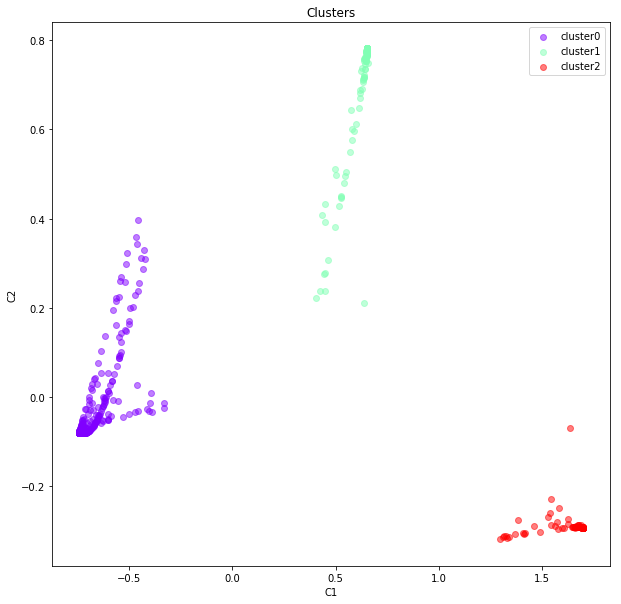

In [86]:
import matplotlib.cm as cm
from matplotlib import pyplot as plt 
n_clusters = 3
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(10,10))
pdf = principalDf_dbscan.copy()
# plt.scatter(subset.C1, subset.C2)
for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.label == label] #subset is a dataframe including all the columns
    plt.scatter(subset.C1, subset.C2, c=color, label='cluster'+str(label),alpha=0.5) # plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('C1')
plt.ylabel('C2')

We see from the grapgh above that the clustering is quite good. The three classes are well separated from each other

PARALLEL PLOT

We will use a parallel plot and a bar graph to investigate which attribute matters in each cluster 

First, we will add the labels to the original data set

In [87]:
XX_dfl.head(3)

,totfood,totalch,totclth,tothous,totfurn,tothlth,tottrsp,totcmnq,totrcre,toteduc,totmisc,label
0,0.187262,0.154462,0.381787,0.160858,0.205355,0.123294,0.125713,0.208678,0.144971,0.284140,0.199687,2
1,0.187262,0.154462,0.381787,0.160858,0.205355,0.123294,0.125713,0.208678,0.144971,0.284140,0.199687,2
2,-0.309691,-0.236916,-0.255200,-0.164006,-0.234674,-0.160486,-0.182042,-0.249690,-0.178124,-0.198115,-0.215703,0


In [88]:
ddd = XX_dfl.label

In [89]:
df = pd.read_csv('final_capstone_project_data.csv') # original data
df.drop(['Unnamed: 0','hid','region','rururb','TOTAL_EXP'], axis = 1, inplace = True)
df.head(2)

,TOTFOOD,TOTALCH,TOTCLTH,TOTHOUS,TOTFURN,TOTHLTH,TOTTRSP,TOTCMNQ,TOTRCRE,TOTEDUC,TOTMISC
0,9437.439453,0.0,1978.0,2569.800049,1128.790039,182.5,2248.399902,138.899994,55.25,1481.5,1081.459961
1,6990.479980,0.0,906.0,10808.799805,1693.709961,21.9,192.500000,370.399994,50.00,5079.0,260.200012


In [90]:
b1 = pd.merge(ddd, df, how='inner', left_index = True, right_index=True) # we are merging on the household id.


Original dataset with label attached

In [91]:
b1.head(4)

,label,TOTFOOD,TOTALCH,TOTCLTH,TOTHOUS,TOTFURN,TOTHLTH,TOTTRSP,TOTCMNQ,TOTRCRE,TOTEDUC,TOTMISC
0,2,9437.439453,0.0,1978.0,2569.800049,1128.790039,182.500000,2248.399902,138.899994,55.250000,1481.5,1081.459961
1,2,6990.479980,0.0,906.0,10808.799805,1693.709961,21.900000,192.500000,370.399994,50.000000,5079.0,260.200012
2,0,3079.566895,0.0,442.0,1240.099976,379.599976,29.200001,0.000000,146.000000,21.900002,827.0,932.660034
3,2,6542.259766,0.0,2435.0,1200.800049,580.959961,29.200001,2579.500000,567.700012,12.500000,1198.0,898.919983


Next, we will find the mean of each household expenditure category for each of the clusters

In [92]:
b1.groupby('label').mean()

,TOTFOOD,TOTALCH,TOTCLTH,TOTHOUS,TOTFURN,TOTHLTH,TOTTRSP,TOTCMNQ,TOTRCRE,TOTEDUC,TOTMISC
label,,,,,,,,,,,
0,3667.370932,14.542541,655.454817,742.977288,309.075706,31.879222,420.006719,149.034261,83.936939,1171.337822,141.019321
1,7086.889629,373.569053,742.789712,658.137652,423.271500,205.307868,647.811045,180.181819,105.770703,1051.703190,202.121383
2,9597.291821,54.960748,2247.570768,2404.339304,1154.940254,185.995101,3110.407862,783.884044,616.412075,4702.824890,916.639694


We can also plot the table above

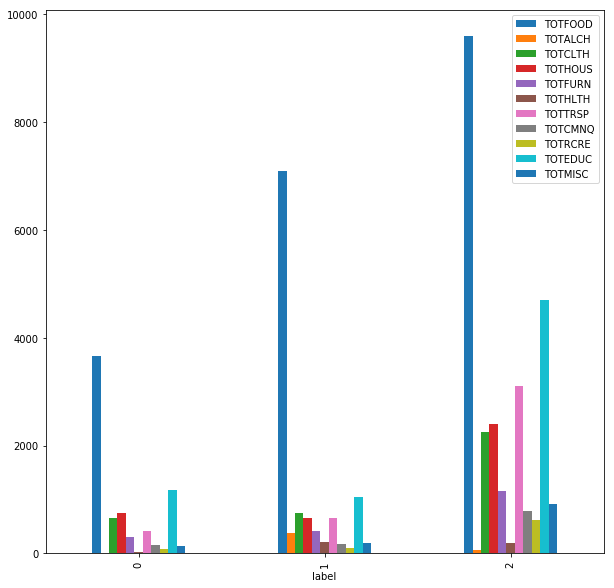

In [93]:
b1.groupby('label').mean().plot(kind='bar', figsize=(10,10))

In the graph above, household expenditures are generally higher in cluster 2, followed by cluster 1 and cluster 0. However, alcohol expenditure and health expenditure appear to be quiet important in cluster 1. For policy purposes, we can investigate further why people with high alcohol expenditure also have high health expenditures. Furthermore, we could view these classes as upper class (high income spenders - class2), middle class(middle income spenders - class1), and low class (low income spenders - class0).  

The discussion above could also be seen from the parallel plot below

No handles with labels found to put in legend.


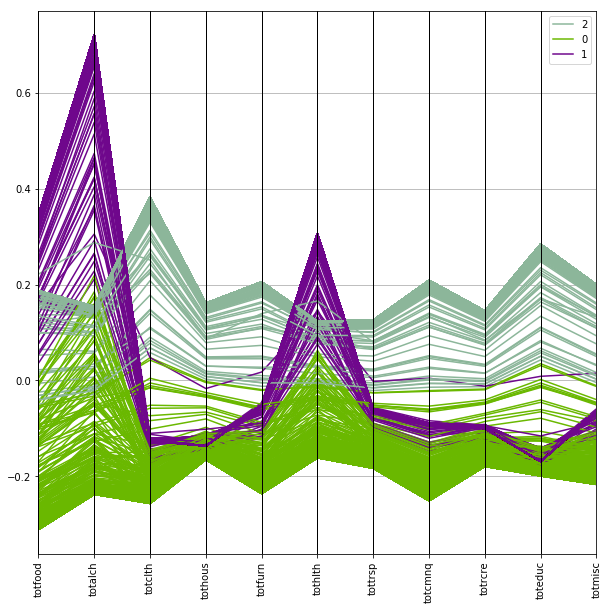

In [94]:
#parallelchord plot
import pandas
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(10,10))
plt.xticks(rotation='vertical')
plt.legend(loc='lower left')
parallel_coordinates(XX_dfl, 'label')
plt.show()

Now we will analyse total expenditure for each cluster. From the graph below, we clearly see the three divisions. This can be a proxy for 3 levels of income (upper, middle and lower income earners). For all 3 classes, higher expenditures on alcohol seems to match higher expenditures on health. 

In [95]:
col_list= list(df)
b1['TOTAL_EXP'] = df[col_list].sum(axis=1)

In [96]:
b2 = b1[['label','TOTAL_EXP']]

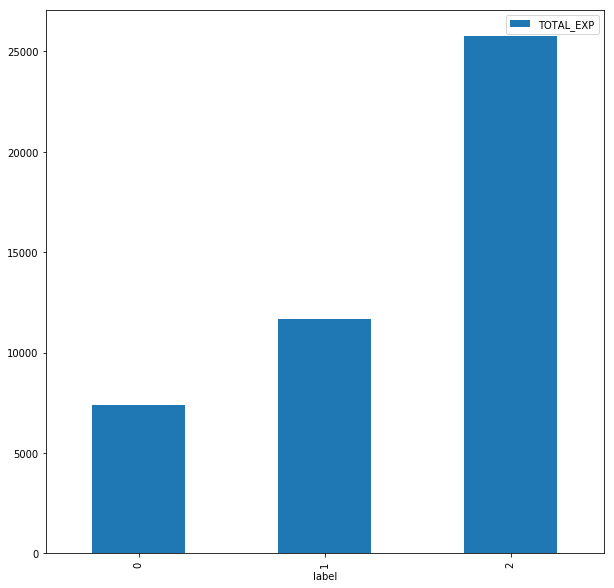

In [97]:
b2.groupby('label').mean().plot(kind='bar', figsize=(10,10))

Counting the number of data points in each cluster

In [98]:
XX_dfl.label.value_counts()

0    5657
2    1964
1    1301
Name: label, dtype: int64

From the results above, we see that most households are in the lower cluster and a few households in the upper cluster

In [100]:
b1.to_csv('b11.csv')

Next, we can view the distribution of total expenditure and compare it to the distribution above

Populating the interactive namespace from numpy and matplotlib


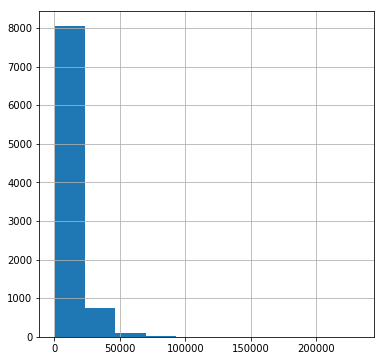

In [2]:
%pylab inline
import pandas as pd
df = pd.read_csv('b11.csv')
df['TOTAL_EXP'].hist(figsize=(6,6))

This graph is skewed to the right, indicating that most people in our sampe are low income spenders which is consistent with our clustering results

#### c. DEC (DEEP EMBEDDING CLUSTERING) + KMEANS

Another deep learning clustering model is the DEC. This model adds an additional clustering layer in a standard autoencoder model at the same time. We will run the algorithm and comapre its performance to the other models

In [101]:
#from keras_dec import DeepEmbeddingClustering
import numpy as np


We will run the DEC clustering algorithm

In [102]:
'''
Keras implementation of deep embedder to improve clustering, inspired by:
"Unsupervised Deep Embedding for Clustering Analysis" (Xie et al, ICML 2016)

Definition can accept somewhat custom neural networks. Defaults are from paper.
'''
import sys
import numpy as np
import keras.backend as K
from keras.initializers import RandomNormal
from keras.engine.topology import Layer, InputSpec
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import SGD
from sklearn.preprocessing import normalize
from keras.callbacks import LearningRateScheduler
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
if (sys.version[0] == 2):
    import cPickle as pickle
else:
    import pickle
import numpy as np

class ClusteringLayer(Layer):
    '''
    Clustering layer which converts latent space Z of input layer
    into a probability vector for each cluster defined by its centre in
    Z-space. Use Kullback-Leibler divergence as loss, with a probability
    target distribution.
    # Arguments
        output_dim: int > 0. Should be same as number of clusters.
        input_dim: dimensionality of the input (integer).
            This argument (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        alpha: parameter in Student's t-distribution. Default is 1.0.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, output_dim)`.
    '''
    def __init__(self, output_dim, input_dim=None, weights=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha
        # kmeans cluster centre locations
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = K.variable(self.initial_weights)
        self.trainable_weights = [self.W]

    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2 /self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q

    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DeepEmbeddingClustering(object):
    def __init__(self,
                 n_clusters,
                 input_dim,
                 encoded=None,
                 decoded=None,
                 alpha=1.0,
                 pretrained_weights=None,
                 cluster_centres=None,
                 batch_size=256,
                 **kwargs):

        super(DeepEmbeddingClustering, self).__init__()

        self.n_clusters = n_clusters
        self.input_dim = input_dim
        self.encoded = encoded
        self.decoded = decoded
        self.alpha = alpha
        self.pretrained_weights = pretrained_weights
        self.cluster_centres = cluster_centres
        self.batch_size = batch_size

        self.learning_rate = 0.1
        self.iters_lr_update = 20000
        self.lr_change_rate = 0.1

        # greedy layer-wise training before end-to-end training:

        self.encoders_dims = [self.input_dim, 500, 500, 2000, 10]

        self.input_layer = Input(shape=(self.input_dim,), name='input')
        dropout_fraction = 0.2
        init_stddev = 0.01

        self.layer_wise_autoencoders = []
        self.encoders = []
        self.decoders = []
        for i  in range(1, len(self.encoders_dims)):
            
            encoder_activation = 'linear' if i == (len(self.encoders_dims) - 1) else 'relu'
            encoder = Dense(self.encoders_dims[i], activation=encoder_activation,
                            input_shape=(self.encoders_dims[i-1],),
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros', name='encoder_dense_%d'%i)
            self.encoders.append(encoder)

            decoder_index = len(self.encoders_dims) - i
            decoder_activation = 'linear' if i == 1 else 'relu'
            decoder = Dense(self.encoders_dims[i-1], activation=decoder_activation,
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros',
                            name='decoder_dense_%d'%decoder_index)
            self.decoders.append(decoder)

            autoencoder = Sequential([
                Dropout(dropout_fraction, input_shape=(self.encoders_dims[i-1],), 
                        name='encoder_dropout_%d'%i),
                encoder,
                Dropout(dropout_fraction, name='decoder_dropout_%d'%decoder_index),
                decoder
            ])
            autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
            self.layer_wise_autoencoders.append(autoencoder)

        # build the end-to-end autoencoder for finetuning
        # Note that at this point dropout is discarded
        self.encoder = Sequential(self.encoders)
        self.encoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
        self.decoders.reverse()
        self.autoencoder = Sequential(self.encoders + self.decoders)
        self.autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))

        if cluster_centres is not None:
            assert cluster_centres.shape[0] == self.n_clusters
            assert cluster_centres.shape[1] == self.encoder.layers[-1].output_dim

        if self.pretrained_weights is not None:
            self.autoencoder.load_weights(self.pretrained_weights)

    def p_mat(self, q):
        weight = q**2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def initialize(self, X, save_autoencoder=False, layerwise_pretrain_iters=50000, finetune_iters=100000):
        if self.pretrained_weights is None:

            iters_per_epoch = int(len(X) / self.batch_size)
            layerwise_epochs = max(int(layerwise_pretrain_iters / iters_per_epoch), 1)
            finetune_epochs = max(int(finetune_iters / iters_per_epoch), 1)

            print('layerwise pretrain')
            current_input = X
            lr_epoch_update = max(1, self.iters_lr_update / float(iters_per_epoch))
            
            def step_decay(epoch):
                initial_rate = self.learning_rate
                factor = int(epoch / lr_epoch_update)
                lr = initial_rate / (10 ** factor)
                return lr
            lr_schedule = LearningRateScheduler(step_decay)

            for i, autoencoder in enumerate(self.layer_wise_autoencoders):
                if i > 0:
                    weights = self.encoders[i-1].get_weights()
                    dense_layer = Dense(self.encoders_dims[i], input_shape=(current_input.shape[1],),
                                        activation='relu', weights=weights,
                                        name='encoder_dense_copy_%d'%i)
                    encoder_model = Sequential([dense_layer])
                    encoder_model.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
                    current_input = encoder_model.predict(current_input)

                autoencoder.fit(current_input, current_input, 
                                batch_size=self.batch_size, epochs=layerwise_epochs, callbacks=[lr_schedule])
                self.autoencoder.layers[i].set_weights(autoencoder.layers[1].get_weights())
                self.autoencoder.layers[len(self.autoencoder.layers) - i - 1].set_weights(autoencoder.layers[-1].get_weights())
            
            print('Finetuning autoencoder')
            
            #update encoder and decoder weights:
            self.autoencoder.fit(X, X, batch_size=self.batch_size, epochs=finetune_epochs, callbacks=[lr_schedule])

            if save_autoencoder:
                self.autoencoder.save_weights('autoencoder.h5')
        else:
            print('Loading pretrained weights for autoencoder.')
            self.autoencoder.load_weights(self.pretrained_weights)

        # update encoder, decoder
        # TODO: is this needed? Might be redundant...
        for i in range(len(self.encoder.layers)):
            self.encoder.layers[i].set_weights(self.autoencoder.layers[i].get_weights())

        # initialize cluster centres using k-means
        print('Initializing cluster centres with k-means.')
        if self.cluster_centres is None:
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
            self.y_pred = kmeans.fit_predict(self.encoder.predict(X))
            self.cluster_centres = kmeans.cluster_centers_

        # prepare DEC model
        #self.DEC = Model(inputs=self.input_layer,
        #                 outputs=ClusteringLayer(self.n_clusters,
        #                                        weights=self.cluster_centres,
        #                                        name='clustering')(self.encoder))
        self.DEC = Sequential([self.encoder,
                             ClusteringLayer(self.n_clusters,
                                                weights=self.cluster_centres,
                                                name='clustering')])
        self.DEC.compile(loss='kullback_leibler_divergence', optimizer='adadelta')
        return

    def cluster_acc(self, y_true, y_pred):
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max())+1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        ind = linear_assignment(w.max() - w)
        return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w

    def cluster(self, X, y=None,
                tol=0.01, update_interval=None,
                iter_max=10000,
                save_interval=None,
                **kwargs):

        if update_interval is None:
            # 1 epochs
            update_interval = X.shape[0]/self.batch_size
        print('Update interval', update_interval)

        if save_interval is None:
            # 50 epochs
            save_interval = X.shape[0]/self.batch_size*50
        print('Save interval', save_interval)

        assert save_interval >= update_interval

        train = True
        iteration, index = 0, 0
        self.accuracy = []

        while train:
            sys.stdout.write('\r')
            # cutoff iteration
            if iter_max < iteration:
                print('Reached maximum iteration limit. Stopping training.')
                return self.y_pred

            # update (or initialize) probability distributions and propagate weight changes
            # from DEC model to encoder.
            if iteration % update_interval == 0:
                self.q = self.DEC.predict(X, verbose=0)
                self.p = self.p_mat(self.q)

                y_pred = self.q.argmax(1)
                delta_label = ((y_pred == self.y_pred).sum().astype(np.float32) / y_pred.shape[0])
                if y is not None:
                    acc = self.cluster_acc(y, y_pred)[0]
                    self.accuracy.append(acc)
                    print('Iteration '+str(iteration)+', Accuracy '+str(np.round(acc, 5)))
                else:
                    print(str(np.round(delta_label*100, 5))+'% change in label assignment')

                if delta_label < tol:
                    print('Reached tolerance threshold. Stopping training.')
                    train = False
                    continue
                else:
                    self.y_pred = y_pred

                for i in range(len(self.encoder.layers)):
                    self.encoder.layers[i].set_weights(self.DEC.layers[0].layers[i].get_weights())
                self.cluster_centres = self.DEC.layers[-1].get_weights()[0]

            # train on batch
            sys.stdout.write('Iteration %d, ' % iteration)
            if (index+1)*self.batch_size > X.shape[0]:
                loss = self.DEC.train_on_batch(X[index*self.batch_size::], self.p[index*self.batch_size::])
                index = 0
                sys.stdout.write('Loss %f' % loss)
            else:
                loss = self.DEC.train_on_batch(X[index*self.batch_size:(index+1) * self.batch_size],
                                               self.p[index*self.batch_size:(index+1) * self.batch_size])
                sys.stdout.write('Loss %f' % loss)
                index += 1

            # save intermediate
            if iteration % save_interval == 0:
                z = self.encoder.predict(X)
                pca = PCA(n_components=2).fit(z)
                z_2d = pca.transform(z)
                clust_2d = pca.transform(self.cluster_centres)
                # save states for visualization
                pickle.dump({'z_2d': z_2d, 'clust_2d': clust_2d, 'q': self.q, 'p': self.p},
                            open('c'+str(iteration)+'.pkl', 'wb'))
                # save DEC model checkpoints
                self.DEC.save('DEC_model_'+str(iteration)+'.h5')

            iteration += 1
            sys.stdout.flush()
        return

Building the model

In [103]:
c = DeepEmbeddingClustering(n_clusters=3, input_dim=11)

Defining the input data

In [104]:
xx = XX_df.values

Training the clustering model

In [105]:
c.initialize(xx, finetune_iters=1000, layerwise_pretrain_iters=1000)
#cl = c.cluster(xx, y=None)

layerwise pretrain
Epoch 1/29
8922/8922 [==============================] - 1s 138us/step - loss: 0.0418
Epoch 2/29
8922/8922 [==============================] - 0s 19us/step - loss: 0.0230
Epoch 3/29
8922/8922 [==============================] - 0s 33us/step - loss: 0.0084
Epoch 4/29
8922/8922 [==============================] - 0s 20us/step - loss: 0.0054
Epoch 5/29
8922/8922 [==============================] - 0s 23us/step - loss: 0.0032
Epoch 6/29
8922/8922 [==============================] - 0s 18us/step - loss: 0.0022
Epoch 7/29
8922/8922 [==============================] - 0s 30us/step - loss: 0.0020
Epoch 8/29
8922/8922 [==============================] - 0s 21us/step - loss: 0.0019
Epoch 9/29
8922/8922 [==============================] - 0s 25us/step - loss: 0.0018
Epoch 10/29
8922/8922 [==============================] - 0s 19us/step - loss: 0.0018
Epoch 11/29
8922/8922 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 12/29
8922/8922 [==============================]

Finding the clusters. NB: we spcified three clusters to make it comparable to the other models

In [42]:
cl = c.cluster(xx, y=None)

Update interval 34.8515625
Save interval 1742.578125
100.0% change in label assignment
Reached maximum iteration limit. Stopping training.


In [43]:
cl

array([2, 2, 1, ..., 1, 1, 1])

In [106]:
xx.shape

(8922, 11)

In [107]:
cl.shape

(8922,)

In [108]:
cl.max()

2

In [109]:
cl.min()

0

Next, we will check the silhouette coefficient. In the results below, we that it performs poorly compared to the previous model

In [111]:
#from sklearn.metrics import silhouette_samples, silhouette_score
#from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xx, cl))

Silhouette Coefficient: 0.417


DEC DOES NOT IMPROVE THE CLUSTERING

#### d. AUTO ENCODING + HDBSCAN

In [3]:
#!pip install --upgrade --user numpy

In [2]:
#!pip install hdbscan

In [1]:
import hdbscan

In [1]:
import pandas as pd
x = pd.read_csv('XX_df.csv')
x.drop(['Unnamed: 0'], axis = 1, inplace = True)
x.head(2)

,totfood,totalch,totclth,tothous,totfurn,tothlth,tottrsp,totcmnq,totrcre,toteduc,totmisc
0,0.187262,0.154462,0.381787,0.160858,0.205355,0.123294,0.125713,0.208678,0.144971,0.28414,0.199687
1,0.187262,0.154462,0.381787,0.160858,0.205355,0.123294,0.125713,0.208678,0.144971,0.28414,0.199687


Defining input values

In [2]:
xx = x.values

Building the HDBSCAN MODEL

In [8]:
# Compute HDBSCAN - best model
hdb = hdbscan.HDBSCAN().fit(xx) # we do not manually specify eps or min_sample or a metric

Obtain the labels

In [9]:
hdb.labels_

array([ 38,  38,  71, ..., 271,  -1, 271])

In [10]:
n_clusters_ = hdb.labels_.max() + 1
print('number of clusters is ', n_clusters_)

number of clusters is  331


This number of clusters is not realistic for our dataset, and hence we donot consider this model to to a good model

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xx, hdb.labels_))

Silhouette Coefficient: 0.568


Nevertheless, the silhouette score is higher compared to for example HDBSCAN

#### e. AUTOENCODING + DBSCAN

Defining input data. This inout data is from our auto encoder model

In [3]:
X =  x.values

Building the model

In [4]:
from sklearn.cluster import DBSCAN
import numpy as np
# Compute DBSCAN - best model
db = DBSCAN(eps=0.08, min_samples=10, metric='euclidean').fit(X) # we set minimum sample in each cluster to be 100
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

Finding the number of clusters and the number of noise points

In [5]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [6]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 70


Estimating silhouette coefficient

In [8]:
#from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.982


The silhouette coefficient is almost the same as the results under (autoencoder + kmeans). We will check how the parallel plot compares to the parallel plot under (autoencoder + kmeans)

Adding labels to table

In [9]:
XX_dfl2 = pd.DataFrame({'totfood':X[:,0],'totalch':X[:,1], 'totclth':X[:,2],'tothous':X[:,3],'totfurn':X[:,4], 'tothlth':X[:,5],
                       'tottrsp':X[:,6],'totcmnq':X[:,7], 'totrcre':X[:,8],'toteduc':X[:,9],'totmisc':X[:,10], 'label':labels})

Visualizing the clusters

PCA Projection to 2D

Now, let's try to visualize the cluster, although we have only one cluster. First, lets use PCA to reduce the dimension of the data to two dimensions


In [10]:
XX_dfl2.to_csv('XX_dfl2.csv')

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(XX_dfl2)

principalDf_dbscan = pd.DataFrame(data = principalComponents
             , columns = ['C1', 'C2'])

In [12]:
principalDf_dbscan['label'] = XX_dfl2.label

In [13]:
principalDf_dbscan.head(2)

,C1,C2,label
0,1.317072,0.251803,0
1,1.317072,0.251803,0


In [14]:
%matplotlib

Using matplotlib backend: agg


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'C2')

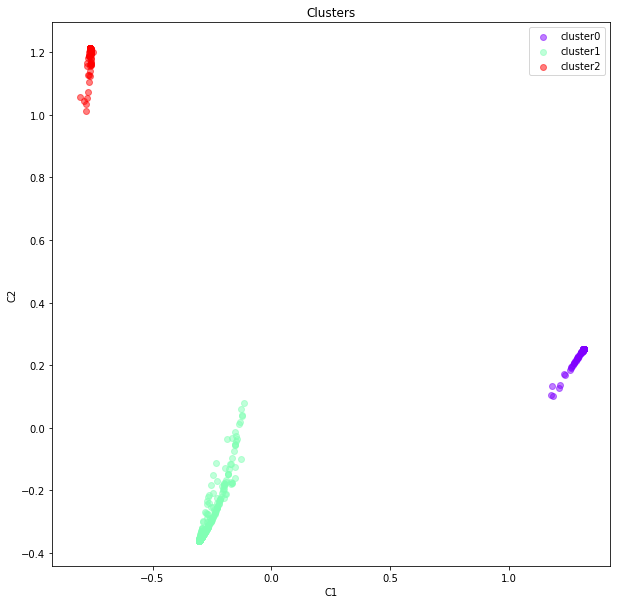

In [15]:
import matplotlib.cm as cm
from matplotlib import pyplot as plt 
n_clusters = n_clusters_
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(10,10))
pdf = principalDf_dbscan.copy()
# plt.scatter(subset.C1, subset.C2)
for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.label == label] #subset is a dataframe including all the columns
    plt.scatter(subset.C1, subset.C2, c=color, label='cluster'+str(label),alpha=0.5) # plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('C1')
plt.ylabel('C2')

From the figure above, we see disticnt non overlapping clusters. This is somehow similar to the case under (autoencoder + kmeans)

Next, we will calculate mean household expenditures for each expenditure category across the 3 clusters

In [16]:
XX_dfl2.head(3)

,totfood,totalch,totclth,tothous,totfurn,tothlth,tottrsp,totcmnq,totrcre,toteduc,totmisc,label
0,0.187262,0.154462,0.381787,0.160858,0.205355,0.123294,0.125713,0.208678,0.144971,0.284140,0.199687,0
1,0.187262,0.154462,0.381787,0.160858,0.205355,0.123294,0.125713,0.208678,0.144971,0.284140,0.199687,0
2,-0.309691,-0.236916,-0.255200,-0.164006,-0.234674,-0.160486,-0.182042,-0.249690,-0.178124,-0.198115,-0.215703,1


In [17]:
ddd = XX_dfl2.label

In [18]:
df = pd.read_csv('final_capstone_project_data.csv') # original data
df.drop(['Unnamed: 0','hid','region','rururb','TOTAL_EXP'], axis = 1, inplace = True)
df.head(2)

,TOTFOOD,TOTALCH,TOTCLTH,TOTHOUS,TOTFURN,TOTHLTH,TOTTRSP,TOTCMNQ,TOTRCRE,TOTEDUC,TOTMISC
0,9437.439453,0.0,1978.0,2569.800049,1128.790039,182.5,2248.399902,138.899994,55.25,1481.5,1081.459961
1,6990.479980,0.0,906.0,10808.799805,1693.709961,21.9,192.500000,370.399994,50.00,5079.0,260.200012


In [19]:
b1 = pd.merge(ddd, df, how='inner', left_index = True, right_index=True) # we are merging on the household id.


In [20]:
b1.head(3)

,label,TOTFOOD,TOTALCH,TOTCLTH,TOTHOUS,TOTFURN,TOTHLTH,TOTTRSP,TOTCMNQ,TOTRCRE,TOTEDUC,TOTMISC
0,0,9437.439453,0.0,1978.0,2569.800049,1128.790039,182.500000,2248.399902,138.899994,55.250000,1481.5,1081.459961
1,0,6990.479980,0.0,906.0,10808.799805,1693.709961,21.900000,192.500000,370.399994,50.000000,5079.0,260.200012
2,1,3079.566895,0.0,442.0,1240.099976,379.599976,29.200001,0.000000,146.000000,21.900002,827.0,932.660034


Mean household expenditure by cluster. Note that the cluster with a label of '-1' contains data points that are noisy and hence we need to remove them

In [21]:
b1.groupby('label').mean()

,TOTFOOD,TOTALCH,TOTCLTH,TOTHOUS,TOTFURN,TOTHLTH,TOTTRSP,TOTCMNQ,TOTRCRE,TOTEDUC,TOTMISC
label,,,,,,,,,,,
-1,7128.125701,25.612572,1225.821572,1685.836402,555.558643,68.392857,916.293856,311.359001,116.797715,2327.214286,323.424571
0,9627.019646,55.362524,2253.967855,2400.274158,1160.493830,187.489706,3130.726191,788.503348,620.511715,4713.033463,922.342148
1,3647.470902,14.514198,652.087522,738.788744,307.546473,31.640537,417.237364,147.702755,83.894147,1165.292937,139.625734
2,7081.380641,378.683480,741.675968,654.500188,422.415368,207.085118,645.465105,180.048233,106.176944,1050.100586,202.074161


Remove noisy data

In [23]:
condition = b1.label != -1
b1 = b1[condition]

we can also visualize the results above

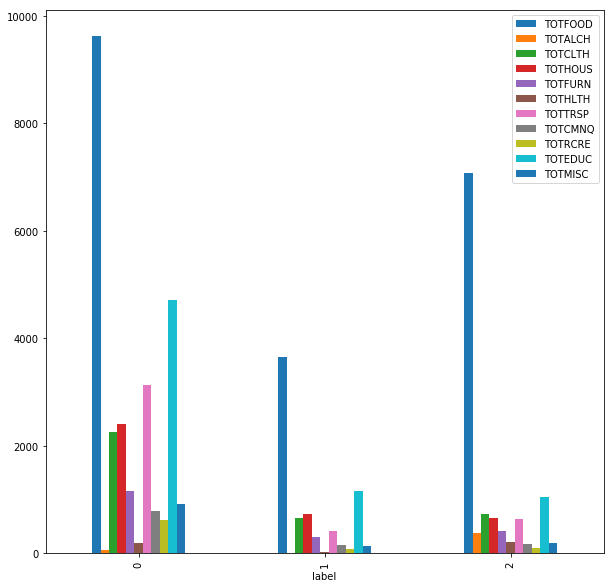

In [24]:
b1.groupby('label').mean().plot(kind='bar', figsize=(10,10))

In the graph above, household expenditures are generally higher in cluster 0, followed by cluster 2 and cluster 1. This is similar to the results under (autoencoder + kmeans)

No handles with labels found to put in legend.


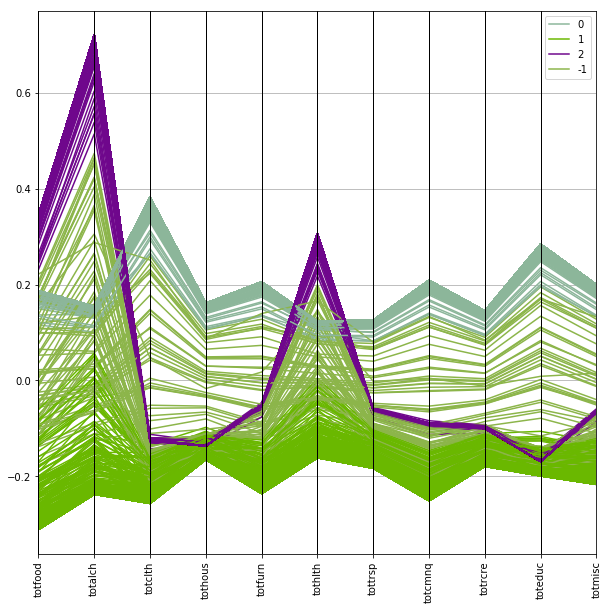

In [25]:
#parallelchord plot
import pandas
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(10,10))
plt.xticks(rotation='vertical')
plt.legend(loc='lower left')
parallel_coordinates(XX_dfl2, 'label')
plt.show()

Again, we see that households with higher alcohol expenditure also have higher health expenditures. Moreover, if we rename the clusters as high, middle and low class households, then we can see that for example alcohol expenditure is higher among the middle and lower class households. For upper class households, the top two important attributes are expenditure on clothing and education. More will be dicussed in the report. 

Next, we will plot mean total expenditure in each cluster

In [26]:
col_list= list(df)
b1['TOTAL_EXP'] = df[col_list].sum(axis=1)

In [27]:
b2 = b1[['label','TOTAL_EXP']]

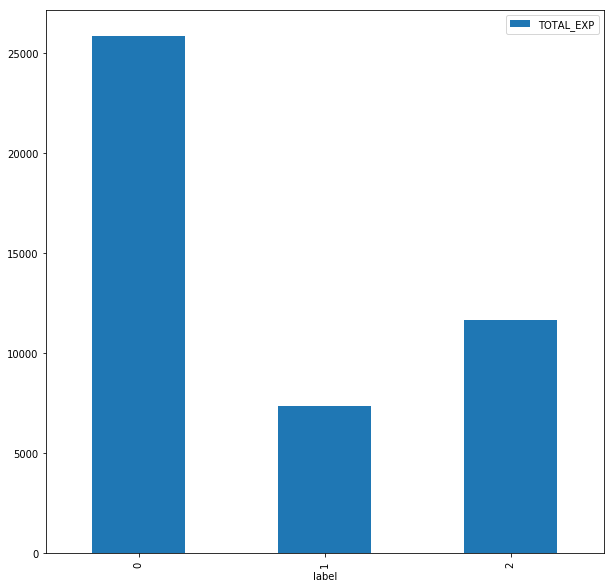

In [28]:
b2.groupby('label').mean().plot(kind='bar', figsize=(10,10))

We see a similar distribution as in the case of (autoencoder + kmeans)

checking the number of households in each cluster

In [29]:
XX_dfl2.label.value_counts()

 1    5626
 0    1945
 2    1281
-1      70
Name: label, dtype: int64

We see a similar distribution as in the case of (autoencoder + kmeans). Most of the households are low income households. More discussion is provided in the report

In [30]:
b1.to_csv('b12.csv')

AUTO-ENCODER: KMEANS (FINDING NUMBER OF CLUSTER USING THE ELBOW METHOD)

In [3]:
import pandas as pd
data_transformed = pd.read_csv('XX_df.csv')
data_transformed .drop(['Unnamed: 0'], axis = 1, inplace = True)

Populating the interactive namespace from numpy and matplotlib


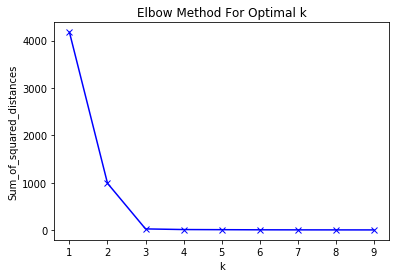

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%pylab inline

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the graph above, we see that the optimal k occurs at 3. Thus, 3 clusters is optimal for our data set. 